In [102]:
import numpy as np
from gPhoton.pipeline import execute_pipeline
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from gPhoton.io.fits_utils import get_fits_data, read_wcs_from_fits
from astropy.visualization import ZScaleInterval
from matplotlib import animation
from IPython.display import HTML


Notebook summary: Exploring consistency and completeness of photometric extraction. Superceded by later work by R. Albach.

Pipeline steps:
1. Run photometry with extraction on NUV
2. Run photometry with extraction on FUV
3. Run photometry on FUV with NUV source positions
4. Run photometry on NUV with FUV source positions
5. Generate a merged catalog from NUV extractions
6. Generate a merged catalog from FUV extractions
7. Generate a merged catalog from all NUV / FUV detections

In [2]:
eclipse = 23456
datadir = "/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/"
edir = f"e{str(eclipse).zfill(5)}"
filepaths = {}
for band in ['NUV','FUV']:
    bstr = band.lower()[0]
    match_on_fuv_fn = f"{datadir}{edir}/{edir}-{bstr}d-b00-f0120-movie-photom-12_8-mof.csv"
    match_on_nuv_fn = f"{datadir}{edir}/{edir}-{bstr}d-b00-f0120-movie-photom-12_8-mon.csv"
    filepaths[band] = {'mof':match_on_fuv_fn,
                         'mon':match_on_nuv_fn}
filepaths

{'NUV': {'mof': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-f0120-movie-photom-12_8-mof.csv',
  'mon': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-f0120-movie-photom-12_8-mon.csv'},
 'FUV': {'mof': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-f0120-movie-photom-12_8-mof.csv',
  'mon': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-f0120-movie-photom-12_8-mon.csv'}}

In [65]:
ra_nuv,dec_nuv,x_nuv,y_nuv = pd.read_csv(filepaths['NUV']['mon'],index_col=None)[['ra','dec','xcentroid','ycentroid']].values.T
ra_fuv,dec_fuv,x_fuv,y_fuv = pd.read_csv(filepaths['FUV']['mof'],index_col=None)[['ra','dec','xcentroid','ycentroid']].values.T
print(len(ra_nuv),len(ra_fuv))

4840 3962


In [91]:
nuv_image_fn = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-ffull-image-r.fits'
fuv_image_fn = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-ffull-image-r.fits'
image = {'NUV':{'count':get_fits_data(nuv_image_fn,dim=1),
                'flag':get_fits_data(nuv_image_fn,dim=2),
                'edge':get_fits_data(nuv_image_fn,dim=2),
                'wcs':read_wcs_from_fits(nuv_image_fn)[1][0]},
         'FUV':{'count':get_fits_data(fuv_image_fn,dim=1),
                'flag':get_fits_data(fuv_image_fn,dim=2),
                'edge':get_fits_data(fuv_image_fn,dim=2),
                'wcs':read_wcs_from_fits(fuv_image_fn)[1][0]},
        }

In [6]:
c = SkyCoord(ra=ra_fuv*u.degree, dec=dec_fuv*u.degree)
catalog = SkyCoord(ra=ra_nuv*u.degree, dec=dec_nuv*u.degree)
catalog_ix, d2d, d3d = c.match_to_catalog_sky(catalog)

In [7]:
match_radius = 3*4.17e-4 # N * galex pixels in decimal degrees
match_radius

0.001251

In [8]:
mask = np.ones(np.array(d2d).shape)
mask[np.where(np.array(d2d)>match_radius)] = 0

In [9]:
d2d_masked = np.ma.array(d2d,mask=mask)
catalog_ix_masked = np.ma.array(catalog_ix,mask=mask)

[]

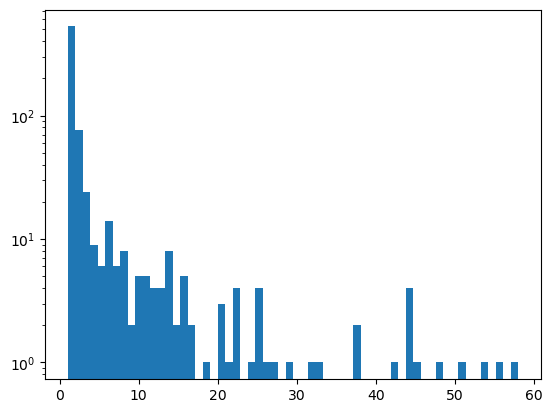

In [10]:
plt.hist([len(np.where(catalog_ix_masked==ix)[0]) for ix in np.unique(catalog_ix_masked).data],bins=60)
plt.semilogy()

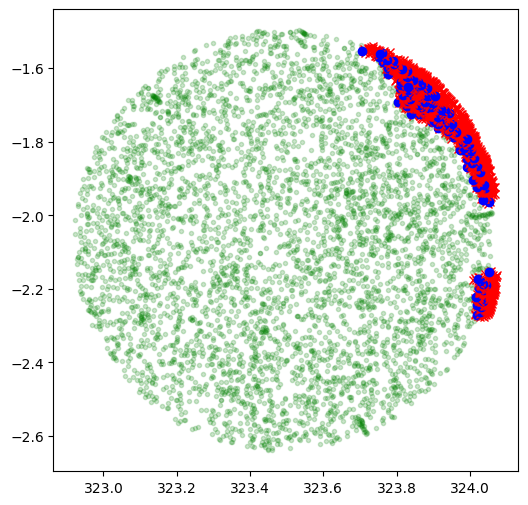

In [11]:
plt.figure(figsize=(6,6))
plt.plot(ra_nuv,dec_nuv,'g.',alpha=0.2)
for i in np.unique(catalog_ix_masked):
    ix = np.where(catalog_ix_masked==i)
    if len(ix[0])>4: # This appears to be the threshhold at which it's all edge effects
        if type(i) is np.ma.core.MaskedConstant:
            continue
        plt.plot(ra_fuv[ix],dec_fuv[ix],'rx')
        plt.plot(ra_nuv[i],dec_nuv[i],'bo')

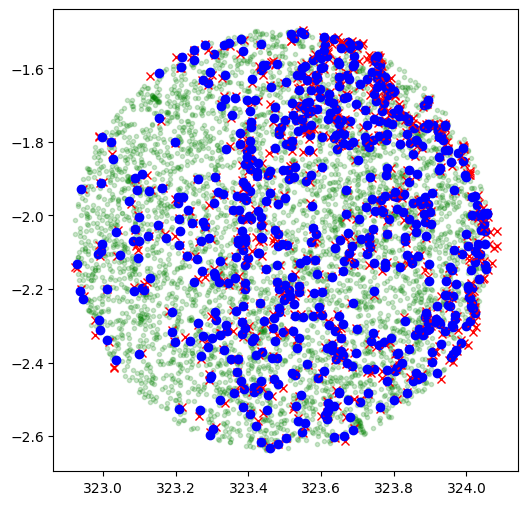

In [12]:
plt.figure(figsize=(6,6))
plt.plot(ra_nuv,dec_nuv,'g.',alpha=0.2)
for i in np.unique(catalog_ix_masked):
    ix = np.where(catalog_ix_masked==i)
    if len(ix[0])<=4: # This appears to be the threshhold at which it's all edge effects
        if type(i) is np.ma.core.MaskedConstant:
            continue
        plt.plot(ra_fuv[ix],dec_fuv[ix],'rx')
        plt.plot(ra_nuv[i],dec_nuv[i],'bo')

In [92]:
image['NUV']['wcs']

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 323.492794193632 -2.06396933577621 
CRPIX : 1533.0 1550.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.000416666666666667 0.000416666666666667 
NAXIS : 3065  3099

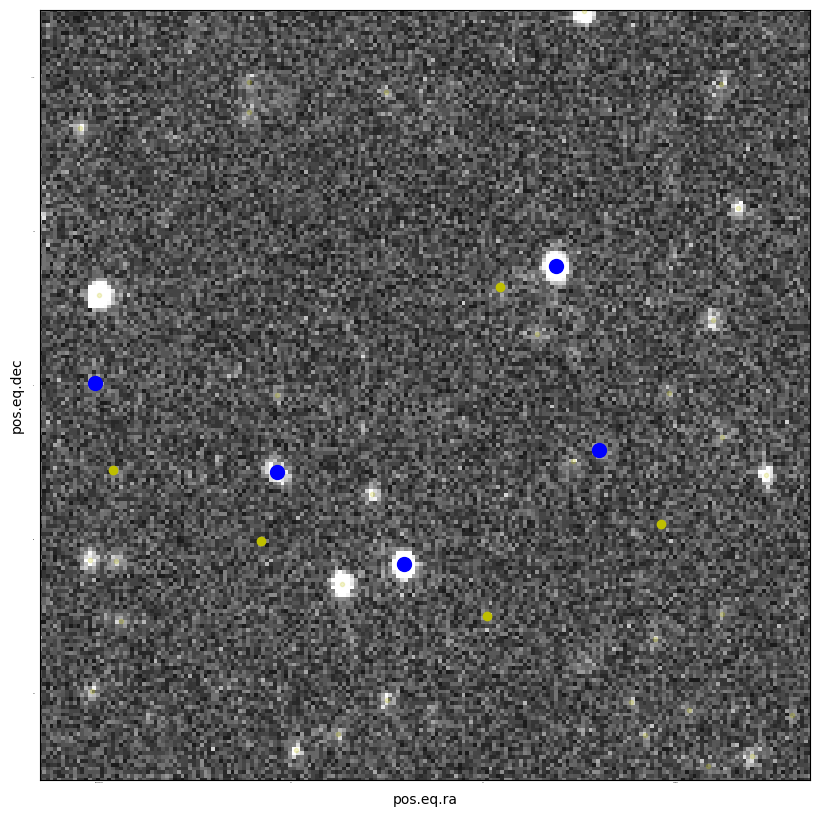

In [101]:
imgband='NUV'
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=image['NUV']['wcs'])
ax.imshow(ZScaleInterval()(image[imgband]['count']),
          cmap="Greys_r", origin="lower",alpha=.9)
# Note that pixel coordinates are assumed to be 0 at the center of the first pixel in each dimension.
# `world_to_pixel` requires a (1,1) pixel offset compared to the outputs of photutils --- idkmiddi
x_nuv,y_nuv = image['NUV']['wcs'].world_to_pixel(SkyCoord(ra=ra_nuv,dec=dec_nuv,unit=u.deg))
x_fuv,y_fuv = image['NUV']['wcs'].world_to_pixel(SkyCoord(ra=ra_fuv,dec=dec_fuv,unit=u.deg))
ax.plot(x_nuv+1,y_nuv+1,'y.',alpha=0.2,markersize=6)

ax.tick_params(axis='both', which='both', length=0, labelsize=0)
ax.set_xticks([]);ax.set_yticks([]);

for i in np.unique(catalog_ix_masked):
    ix = np.where(catalog_ix_masked==i)
    if len(ix[0])<=4: # This appears to be the threshhold at which it's all edge effects
        if type(i) is np.ma.core.MaskedConstant:
            continue
        ax.plot(x_nuv[i]+1,y_nuv[i]+1,'bo',markersize=10)
        ax.plot(x_fuv[ix]+1,y_fuv[ix]+1,'yo')

ax.set_xlim([800,1000]);ax.set_ylim([800,1000]);


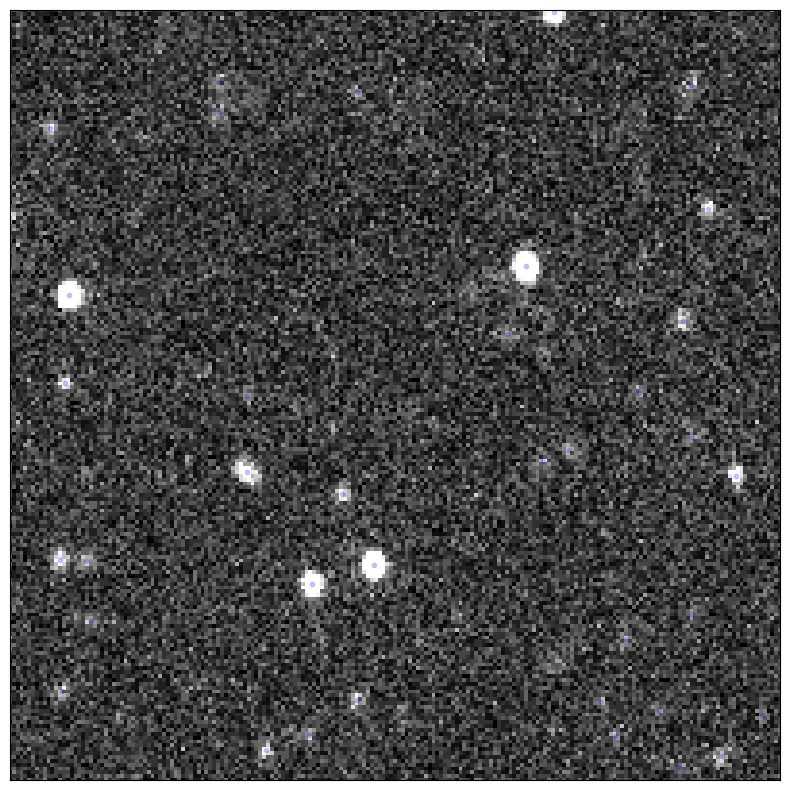

In [67]:
imgband='NUV'
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)#, projection=wcs[0])
ax.imshow(ZScaleInterval()(image[imgband]['count']),
          cmap="Greys_r", origin="lower",alpha=1)
# Note that pixel coordinates are assumed to be 0 at the center of the first pixel in each dimension.
#x,y = wcs.world_to_pixel(SkyCoord(ra=ra_nuv,dec=dec_nuv,unit=u.deg))
ax.plot(x_nuv,y_nuv,'b.',alpha=0.2,markersize=6)

ax.tick_params(axis='both', which='both', length=0, labelsize=0)
ax.set_xticks([]);ax.set_yticks([]);
ax.set_xlim([800,1000]);ax.set_ylim([800,1000]);